In [1]:
import pyforest

In [2]:
sys.path.append(str(Path.cwd().parent.absolute()))

In [3]:
from sklearn.manifold import TSNE
from common.tsfms import get_tsfms
from common.dataset import ColoredMNIST
from networks import MLP, ToyNet

In [4]:
class Extractor:
    def __init__(self, model, names=['layer1.0', 'layer2.0', 'layer3.0', 'aux1', 'aux2', 'aux3', 'fc']):
        self.feats = {}
        self.model = model.eval()

        for name, module in self.model.named_modules():
            if name in names:
                module.register_forward_hook(self.save_output_hook(name))

    def save_output_hook(self, name):
        def func(module, input, output):
            if output.dim() > 2:
                output = F.adaptive_avg_pool2d(output, 1)
                output = output.flatten(1)
            output = output.transpose(0, 1)
            # output = F.normalize(output, dim=-1)
            output = output.cpu().numpy()
            self.feats[name.split('.')[0]] = output
        return func

    def __call__(self, *args, **kwargs):
        self.feats = {}
        with torch.no_grad():
            self.model(*args, **kwargs)
        return self.feats
    
    def to(self, *args, **kwargs):
        self.model = self.model.to(*args, **kwargs)
        return self
    
    def cuda(self, *args, **kwargs):
        self.model = self.model.cuda(*args, **kwargs)
        return self

In [5]:
def select_data(dataset, num_per_class=100, seed=42):
    np.random.seed(seed)
    
    labels = dataset.targets
    labels = [f'{x[0]}{x[1]}' for x in labels]
    
    indexs = []
    record = defaultdict(int)
    
    for i in np.random.permutation(len(labels)):
        label = labels[i]
        if record[label] < num_per_class:
            indexs.append(i)
            record[label] += 1
        else:
            continue

    indexs = np.array(indexs)
    indexs = indexs[np.random.permutation(len(indexs))]
    return indexs

In [6]:
tsfm = get_tsfms('mnist')[-1]
dataset = ColoredMNIST('../data', train=True, transform=tsfm, skewed=0.9, download=True)
indices = select_data(dataset, num_per_class=100, seed=42)
dloader = DataLoader(Subset(dataset, indices), batch_size=len(indices))

Files already downloaded and verified


In [7]:
index = 5
group = 1
feat_dim = 256
model = ToyNet(num_classes=10, feat_dim=feat_dim)
model.fc = MLP(model.fc.in_features, model.feat_dim)
state = torch.load(
    f'../ckpts/mnist.4.{feat_dim}.k{group}'
    f'/mode{index}_skewed0.01_severity1/epoch99.pkl'
)
model.load_state_dict(state['model'], strict=True)
model = Extractor(model).cuda()
input = list(dloader)[0][0].cuda()
feats = model(input)

In [8]:
corrs = torch.load(f'../temp/mnist_corrs_{feat_dim}.pkl')
corrs = corrs[f'mode{index}_group{group}']

In [9]:
embeddings = {}
for key, feat in tqdm(feats.items()):
    embedding = TSNE().fit_transform(feat)
    embeddings[key] = embedding

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
def plot_tsne(name, embeddings, corrs=None, postfix=''):
    plt.figure()
    embedding = embeddings[name]
    x, y = embedding[:, 0], embedding[:, 1]
    if corrs is not None: corrs = corrs[name]
    sc = plt.scatter(x, y, s=6, c=corrs, cmap='viridis')
    plt.colorbar(sc)
    plt.title(f'TSNE of {name}, {postfix}')

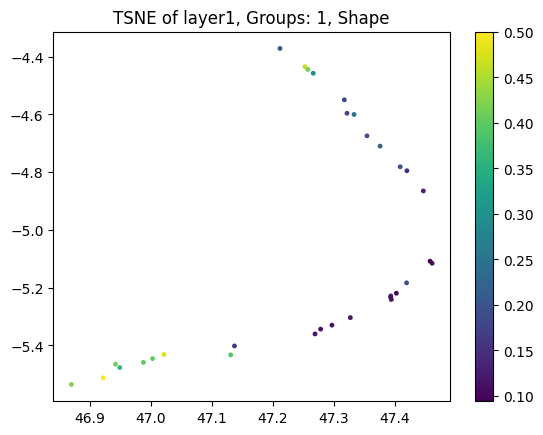

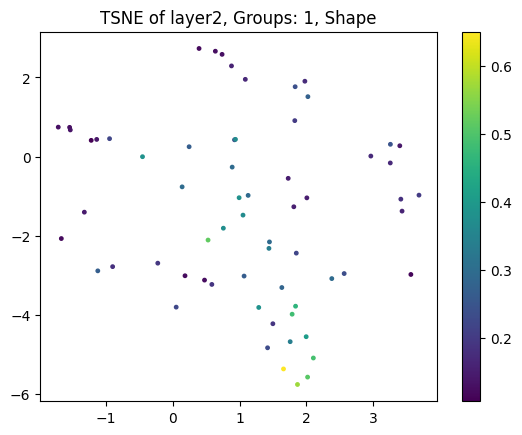

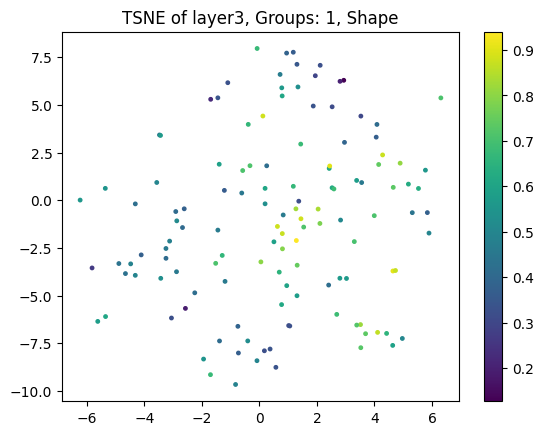

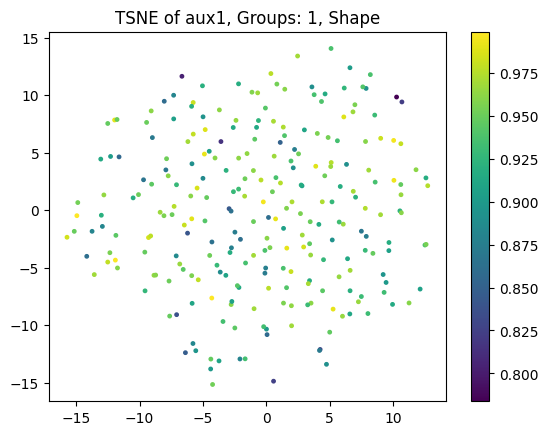

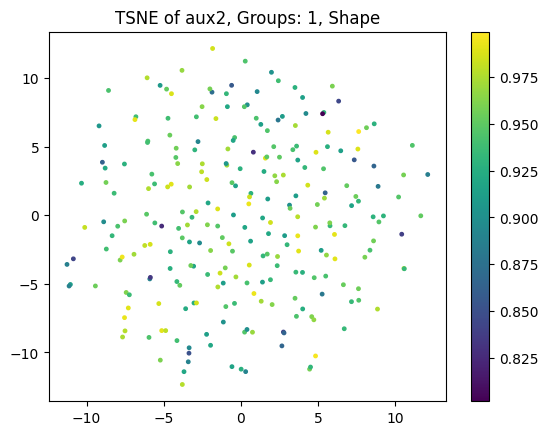

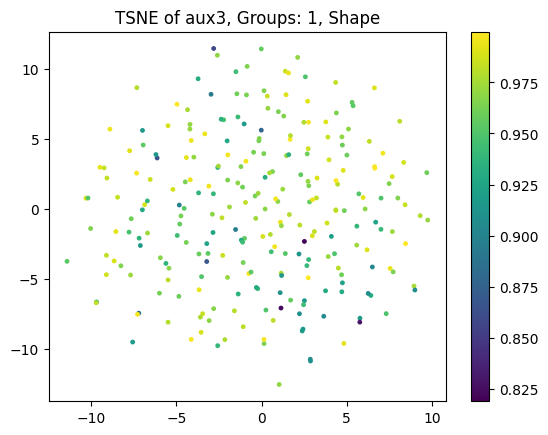

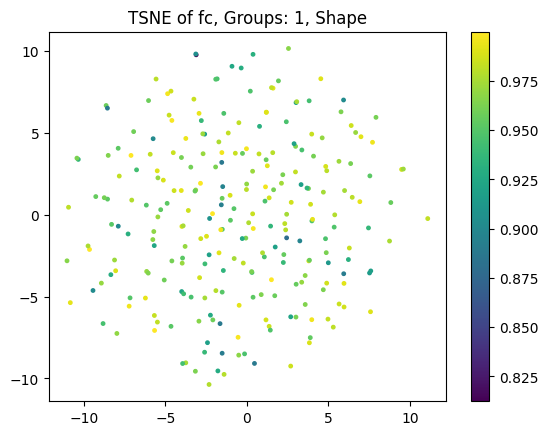

In [11]:
for name in ['layer1', 'layer2', 'layer3', 'aux1', 'aux2', 'aux3', 'fc']:
    plot_tsne(name, embeddings, corrs=corrs['shape'], postfix=f'Groups: {group}, Shape')

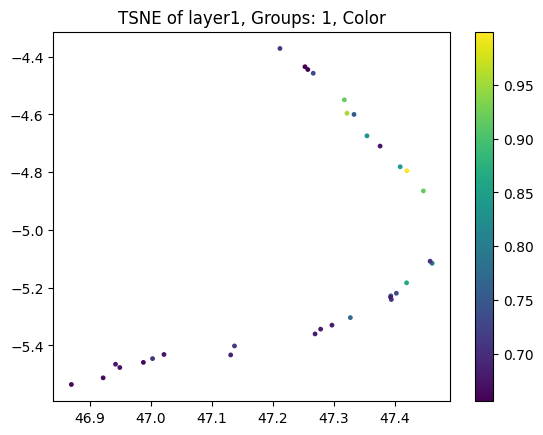

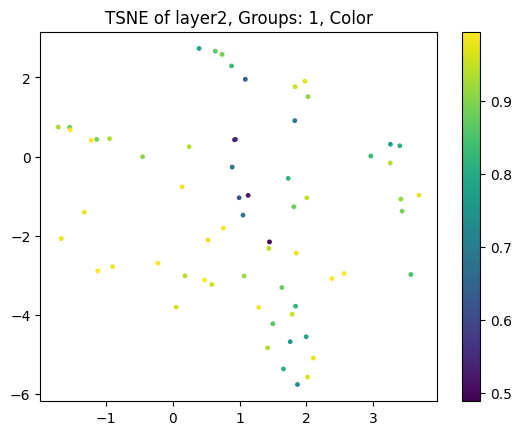

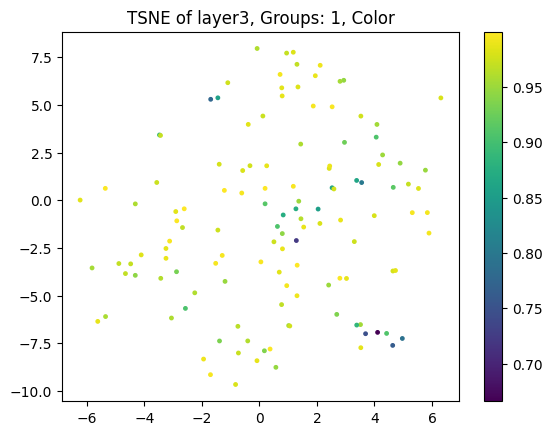

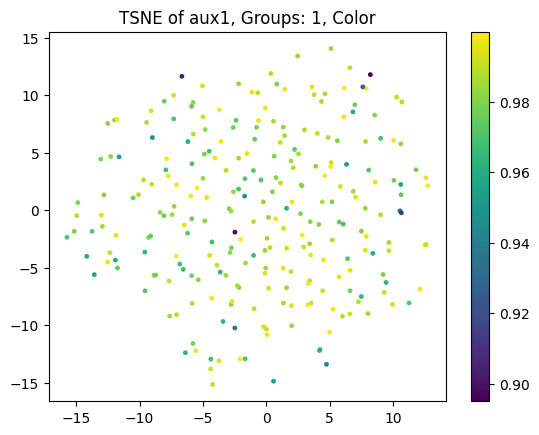

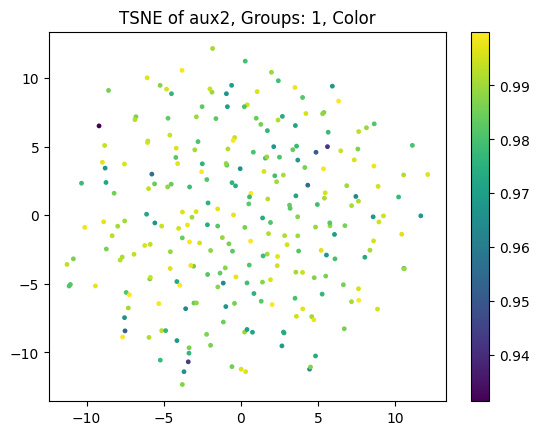

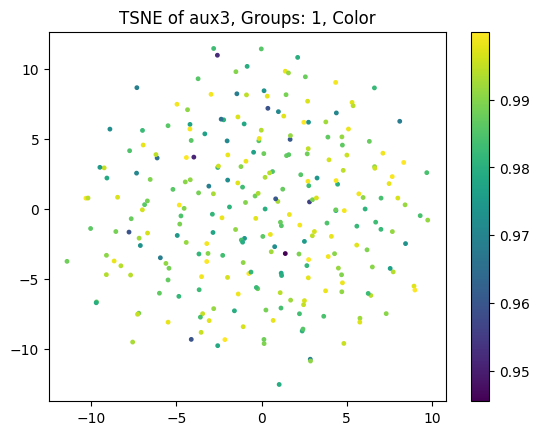

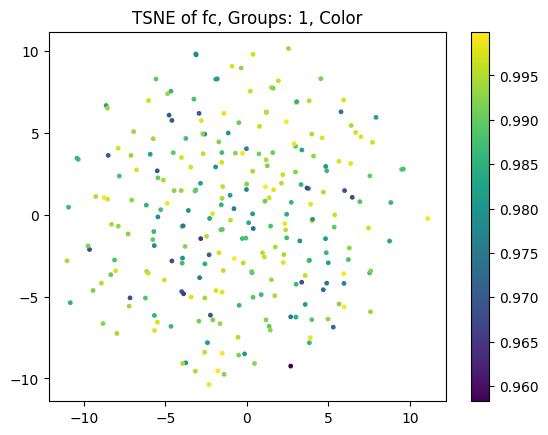

In [12]:
for name in ['layer1', 'layer2', 'layer3', 'aux1', 'aux2', 'aux3', 'fc']:
    plot_tsne(name, embeddings, corrs=corrs['color'], postfix=f'Groups: {group}, Color')